In [6]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.size'] = 15

sns.set(style="darkgrid", font_scale=1.5)

#### Read everything. For now, focus on just all debates.

In [7]:
debates = pd.read_csv('../data/june1_transcript.csv')
debates['month'] = 'june'
df = pd.read_csv('../data/june2_transcript.csv')
df['month'] = 'june'
debates = debates.append(df)
df = pd.read_csv('../data/july1_transcript.csv')
df['month'] = 'july'
debates = debates.append(df)
df = pd.read_csv('../data/july2_transcript.csv')
df['month'] = 'july'
debates = debates.append(df)
df = pd.read_csv('../data/september_transcript.csv')
df['month'] = 'september'
debates = debates.append(df)
df = pd.read_csv('../data/october_transcript.csv')
df['month'] = 'october'
debates = debates.append(df)
df = pd.read_csv('../data/november_transcript.csv')
df['month'] = 'november'
debates = debates.append(df)
df = pd.read_csv('../data/december_transcript.csv')
df['month'] = 'december'
debates = debates.append(df)
df = pd.read_csv('../data/january_transcript.csv')
df['month'] = 'january'
debates = debates.append(df)
df = pd.read_csv('../data/february_transcript.csv')
df['month'] = 'february'
debates = debates.append(df)
debates = debates[['name', 'text', 'month', 'time']]

/mnt/d/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [8]:
key_topics = ["health", "tax", "defense", "budget", "foreign", "China", "Russia", "immigration"]

In [9]:
healthcare_dict = ["health", "healthcare", "Medicaid", "Medicare", "insurance", "Obamacare", "Affordable Care Act", "ACA", "medical", "hospital", "premium", "copay","doctor", "care", ""]
foreign_pol_dict = ["China", "Hong Kong", "Uighurs", "North Korea", "nuclear", "Russia", "Afghanistan", "Saudi Arabia", "Israeli-Palestinian", "Venezuela", "Maduro", "United Nations", "foreign", "foreign policy", "Israel", "Palestinian", "pro-Isreal", "anti-Israel", "Europe", "Yemen", "Gulf", "Middle East", "Iraq"]
defense_dict = ["defense", "security", "war", "military", "alliance", "spending", "arms", "army", "defend", "ally", "allies", "arms sales", "invasion", "invade", "force", "mission", "national security", "troops", "soldiers", "weapon", "nuclear weapon", "combat", "service", "service members", "Al-Qaeda", "threat", "police", "courts", "prison", "Iraq", "Syria", "Afghanistan", "ISIS"]
category_dict = {}
category_dict["healthcare"] = healthcare_dict
category_dict["foreign_policy"] = foreign_pol_dict
category_dict["defense"] = defense_dict


debates['category'] = [[] for i in range(debates.shape[0])]
debates['category']

for i, post in enumerate(debates['text']):
    for category, keywords in category_dict.items():
        for word in keywords:  
            if word in str(post):
                debates['category'].iloc[i].append(category)
                break
debates.head(20)
    

,name,text,month,time,category
0,Lester Holt,"… comment on every topic, but over the course ...",june,NaN,[healthcare]
1,Savannah G.,"All right, so with that business out of the wa...",june,NaN,[healthcare]
2,Senator Warren,Thank you. It’s good to be here.,june,NaN,[healthcare]
3,Savannah G.,"You have many plans. Free college, free childc...",june,NaN,[healthcare]
4,Senator Warren,I think of it this way. Who is this economy re...,june,NaN,"[healthcare, defense]"
5,Senator Warren,It’s doing great for giant oil companies that ...,june,NaN,[healthcare]
6,Savannah G.,"Senator Klobuchar, you called programs like fr...",june,NaN,"[healthcare, defense]"
7,Amy Klobachar,"Well, first the economy. We know that not ever...",june,NaN,[healthcare]
8,Amy Klobachar,"Secondly, I’d use Pell Grants. I’d double them...",june,NaN,[healthcare]
9,Savannah G.,That’s time. Thank you. Congressman O’Rourke. ...,june,NaN,"[healthcare, defense]"


In [24]:
debate_df.head()

,name,time,text,seconds_since_start,duration
0,Rachel Maddow,(00:01),We’re in the middle of the fourth presidential...,1,44.0
1,Senator Warren,(00:45),Of course I will. And the obvious answer is to...,45,43.0
2,Senator Warren,(01:28),"The corruption, how money buys its way into Wa...",88,37.0
3,Rachel Maddow,(02:05),"Senator Warren, thank you, Senator Klobuchar, ...",125,16.0
4,Amy Klobuchar,(02:21),I have made it very clear that this is impeach...,141,54.0


In [7]:
debate_df.iloc[358]

name                                       Senator Warren
time                                           (02:09:02)
text    -and a chance to become a candidate for Presid...
Name: 358, dtype: object

In [8]:
regexed_time = debate_df['time'].str.extract(r'\((?P<hours>[0-9]*)[:]*(?P<mins>[0-9]*)[:](?P<seconds>[0-9]*)\)')

def f(row):
    if len(row['mins']) == 0:
        # Means there is no hour. The column hour is actually minutes.
        val = int(row['hours']) * 60 + int(row['seconds'])
    else:
        # Means there is a hour column too.
        val = int(row['hours']) * 60 * 60 + int(row['mins']) * 60 + int(row['seconds'])
    return val

debate_df['seconds_since_start'] = regexed_time.apply(f, axis=1)
debate_df['duration'] = - debate_df['seconds_since_start'] + debate_df['seconds_since_start'].shift(-1)

In [9]:
debate_df.head()

,name,time,text,seconds_since_start,duration
0,Rachel Maddow,(00:01),We’re in the middle of the fourth presidential...,1,44.0
1,Senator Warren,(00:45),Of course I will. And the obvious answer is to...,45,43.0
2,Senator Warren,(01:28),"The corruption, how money buys its way into Wa...",88,37.0
3,Rachel Maddow,(02:05),"Senator Warren, thank you, Senator Klobuchar, ...",125,16.0
4,Amy Klobuchar,(02:21),I have made it very clear that this is impeach...,141,54.0


In [10]:
# Remove all but candidataes.
candidates = ['Amy Klobuchar', 'Andrew Yang', 'Bernie Sanders', 'Joe Biden', 'Kamla Harris', \
            'Pete Buttigieg', 'Senator Booker', 'Senator Warren', 'Tom Steyer', 'Tulsi Gabbard']
filtered_df = debate_df[debate_df['name'].isin(candidates)]

In [11]:
mean_duration_df = filtered_df.groupby('name')['duration'].mean()

mean_duration_df

name
Amy Klobuchar     32.350000
Andrew Yang       30.461538
Bernie Sanders    41.470588
Joe Biden         30.520000
Pete Buttigieg    27.250000
Senator Booker    26.500000
Senator Warren    28.750000
Tom Steyer        22.772727
Tulsi Gabbard     30.833333
Name: duration, dtype: float64

Text(0, 0.5, 'Average Duration (s)')

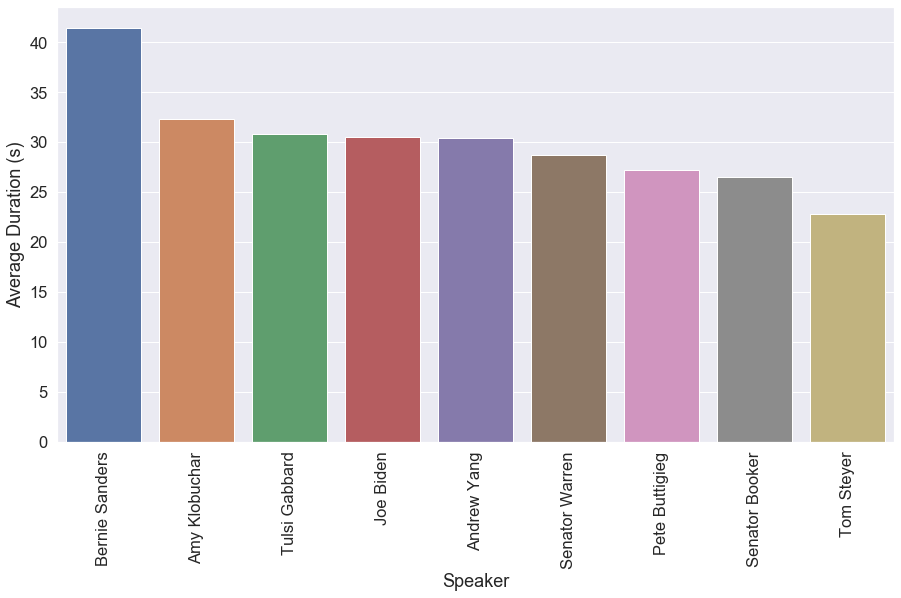

In [12]:
#mean_duration_reset_df = mean_duration_df.reset_index(drop=False)

plt.figure(figsize=(15,8))
b = sns.barplot(x='name', y='duration', data=mean_duration_df.reset_index(drop=False).sort_values(by='duration', ascending=False));
c = plt.setp(b.get_xticklabels(), rotation=90)
plt.xlabel("Speaker")
plt.ylabel("Average Duration (s)")

In [13]:
total_duration_df = filtered_df.groupby('name')['duration'].sum() / 60

total_duration_df

name
Amy Klobuchar     10.783333
Andrew Yang        6.600000
Bernie Sanders    11.750000
Joe Biden         12.716667
Pete Buttigieg    12.716667
Senator Booker    11.483333
Senator Warren    13.416667
Tom Steyer         8.350000
Tulsi Gabbard      9.250000
Name: duration, dtype: float64

Text(0, 0.5, 'Total Duration (mins)')

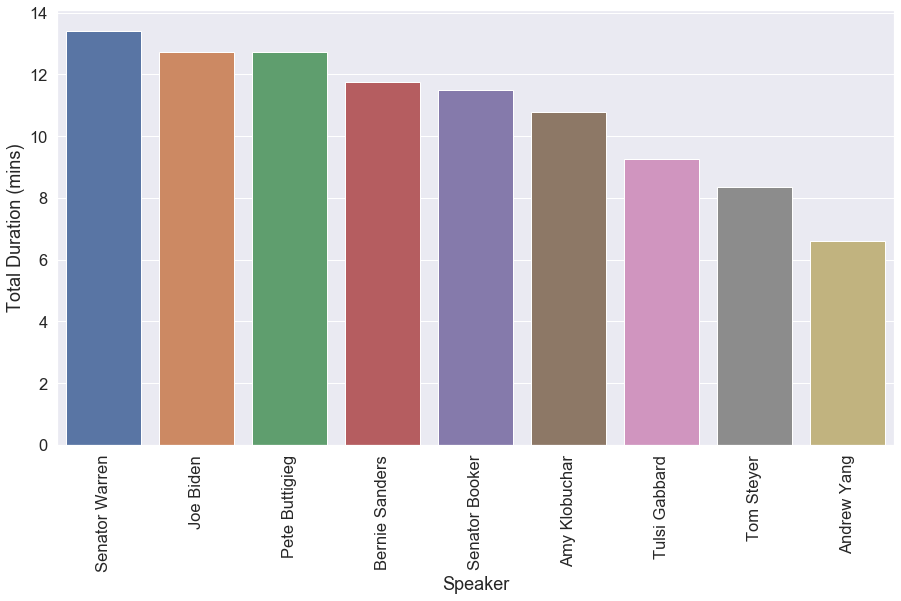

In [14]:
plt.figure(figsize=(15,8))
b = sns.barplot(x='name', y='duration', data=total_duration_df.reset_index(drop=False).sort_values(by='duration', ascending=False));
c = plt.setp(b.get_xticklabels(), rotation=90)
plt.xlabel("Speaker")
plt.ylabel("Total Duration (mins)")

In [15]:
all_words = ' '.join(filtered_df['text']).lower()

In [16]:
all_tokenized_words = nltk.tokenize.word_tokenize(all_words)
#al_words_dist = nltk.FreqDist(w.lower() for w in all_tokenized_words)

stopwords = nltk.corpus.stopwords.words('english')
all_words_except_stop_dist = nltk.FreqDist(w.lower() for w in all_tokenized_words if w not in stopwords and w.isalpha())   

In [17]:
all_words_except_stop_dist

FreqDist({'people': 138, 'president': 84, 'going': 73, 'country': 68, 'think': 67, 'one': 60, 'need': 58, 'make': 54, 'american': 54, 'want': 51, ...})

(-0.5, 4999.5, 4999.5, -0.5)

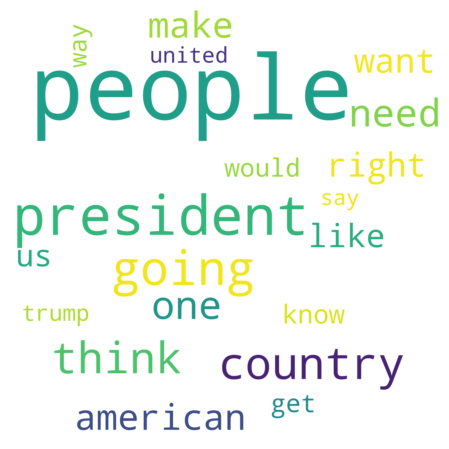

In [18]:
from wordcloud import WordCloud

plt.figure(figsize=(15,8))
wc = WordCloud(background_color="white", scale=10, width=500, height=500, max_words=20, relative_scaling=1, normalize_plurals=False).generate_from_frequencies(all_words_except_stop_dist)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [19]:
# Now do the same but for each of the candidates.

all_freq_dist = {}
for candidate in candidates:
    words_by_this_candidate = filtered_df[filtered_df['name'] == candidate]
    all_words_candidate = ' '.join(words_by_this_candidate['text']).lower()
    
    all_tokenized_words_cand = nltk.tokenize.word_tokenize(all_words_candidate)
    all_words_except_stop_dist_cand = nltk.FreqDist(w.lower() for w in all_tokenized_words_cand if w not in stopwords and w.isalpha())   
    all_freq_dist[candidate] = all_words_except_stop_dist_cand
    
    

['Amy Klobuchar' 'Andrew Yang' 'Bernie Sanders' 'Joe Biden'
 'Pete Buttigieg' 'Senator Booker' 'Senator Warren' 'Tom Steyer'
 'Tulsi Gabbard']
i =  1
Amy Klobuchar
<FreqDist with 463 samples and 829 outcomes>
i =  2
Andrew Yang
<FreqDist with 357 samples and 554 outcomes>
i =  3
Bernie Sanders
<FreqDist with 455 samples and 787 outcomes>
i =  4
Joe Biden
<FreqDist with 495 samples and 956 outcomes>
i =  5
Pete Buttigieg
<FreqDist with 602 samples and 1046 outcomes>
i =  6
Senator Booker
<FreqDist with 551 samples and 978 outcomes>
i =  7
Senator Warren
<FreqDist with 551 samples and 1083 outcomes>
i =  8
Tom Steyer
<FreqDist with 339 samples and 663 outcomes>
i =  9
Tulsi Gabbard
<FreqDist with 434 samples and 740 outcomes>


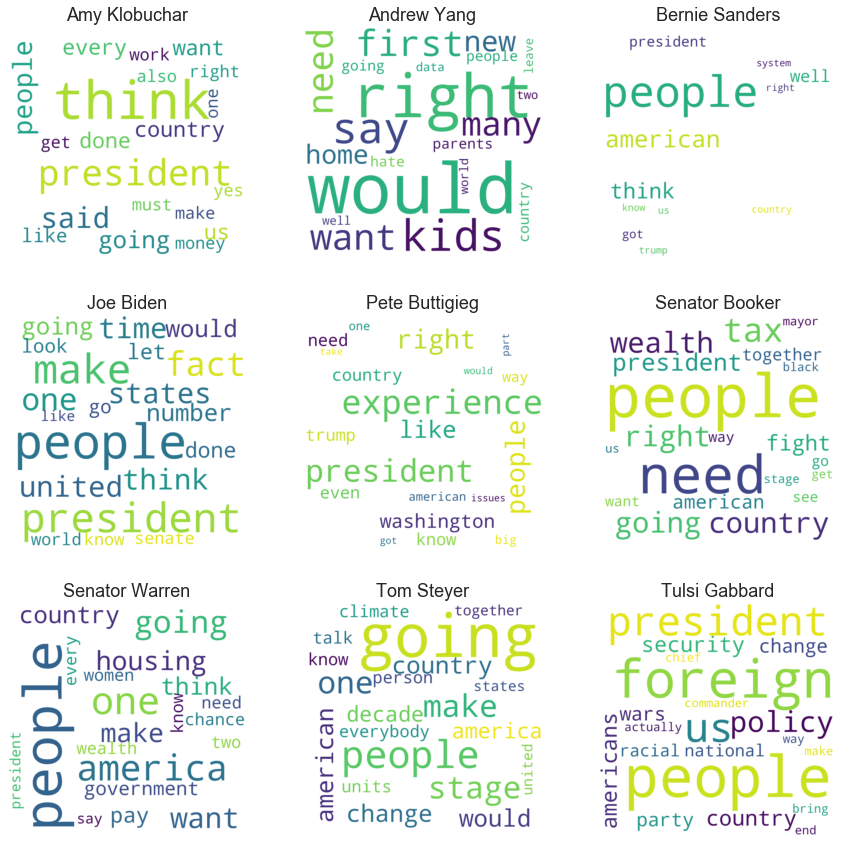

In [20]:
non_zero_candidates = total_duration_df.index.values
print(non_zero_candidates)
fig=plt.figure(figsize=(15, 15))
columns = 3
rows = 3
for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    print("i = ", i)
    print(non_zero_candidates[i - 1])
    print(all_freq_dist[non_zero_candidates[i - 1]])
    wc = WordCloud(background_color="white", scale=25, width=100, height=100, max_words=20, relative_scaling=1, normalize_plurals=False).generate_from_frequencies(all_freq_dist[non_zero_candidates[i - 1]])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    ax.set_title((non_zero_candidates[i - 1]))
    
plt.show()